In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from typing import Tuple, Dict, List

class ImageFolderCustom(Dataset):
    def __init__(self, root_dir: str, partition:str='train', transform=None) -> None:
        self.targ_dir = os.path.join(root_dir, partition)
        self.paths = list(pathlib.Path(self.targ_dir).glob("*/*.jpeg"))
        self.readable_classes_dict = extract_readable_imagenet_labels(os.path.join(root_dir, 'LOC_synset_mapping.txt'))
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(self.targ_dir, self.readable_classes_dict)

    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        readable_class_name = self.readable_classes_dict[class_name]
        class_idx = self.class_to_idx[readable_class_name]

        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx
        
def extract_readable_imagenet_labels(file_path: os.path) -> dict:
    """
    Helper function for storing imagenet human read-able 
    class mappings. Mapping downloaded from 
    https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a 
    """
    class_dict = {}

    with open(file_path, 'r') as file:
        for line in file:
            words = line.strip().split()
            class_dict[words[0]] = words[1].rstrip(',') # Incase there are several readable labels which are comma separated. 

    return class_dict


def find_classes(directory: str, readable_classes_dict: dict) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    readable_classes = [readable_classes_dict.get(key) for key in classes]
    
    if not readable_classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    class_to_idx = {cls_name: i for i, cls_name in enumerate(readable_classes)}
    return readable_classes, class_to_idx

In [27]:
train_data = ImageFolderCustom(r'C:\data\imagenet')
import torchvision.transforms as transforms
val_data = ImageFolderCustom(r'C:\data\imagenet', 'train', transforms.Compose([
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
            ]))
val_data.class_to_idx = train_data.class_to_idx

In [23]:
print(val_data.targ_dir)
val_data.paths

C:\data\imagenet\val


[WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00000293.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00002138.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00003014.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00006697.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00007197.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00009111.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00009191.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00009346.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00009379.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00009396.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00010306.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00011233.JPEG'),
 WindowsPath('C:/data/imagenet/val/n01440764/ILSVRC2012_val_00011993.JPEG'),

In [29]:
img, label = val_data.__getitem__(5)
img.shape

torch.Size([3, 224, 224])

In [39]:
import xml.etree.ElementTree as ET
tree = ET.parse(r"C:\data\imagenet1k\ILSVRC\Annotations\CLS-LOC\train\n01440764\n01440764_18.xml")
root = tree.getroot()

In [40]:
bndbox = root.find(".//bndbox")

print(bndbox)

xmin = int(bndbox.find("xmin").text)
ymin = int(bndbox.find("ymin").text)
xmax = int(bndbox.find("xmax").text)
ymax = int(bndbox.find("ymax").text)

print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")


<Element 'bndbox' at 0x000001EFFCB4E3E0>
xmin: 1, ymin: 198, xmax: 317, ymax: 352


In [41]:

import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [42]:
from torchvision.io import decode_image

img = decode_image(r"C:\data\imagenet1k\ILSVRC\Data\CLS-LOC\train\n01440764\n01440764_18.JPEG")

In [45]:
import torch

coords_tensor = torch.tensor([[xmin, ymin, xmax, ymax]])

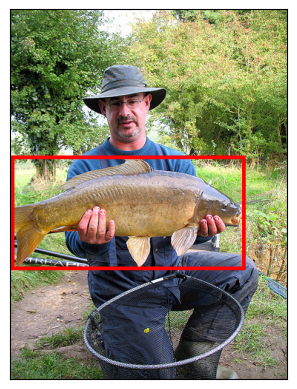

In [46]:
from torchvision.utils import draw_bounding_boxes

drawn_boxes = draw_bounding_boxes(img, coords_tensor, colors="red", width=5)
show(drawn_boxes)

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
transforms = A.Compose([A.SmallestMaxSize(max_size=224),
                        ToTensorV2()], bbox_params=A.BboxParams(format='coco', min_area=0, min_visibility=0))



In [43]:
import os
import pathlib
import logging
from PIL import Image
from typing import Tuple, Dict, List

import torch
import torch.utils.data
from torch.utils.data import (
    Dataset,
    default_collate
)
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import v2
import torchvision

import xml.etree.ElementTree as ET

logger = logging.getLogger()

def extract_readable_imagenet_labels(file_path: os.path) -> dict:
    """
    Helper function for storing imagenet human read-able 
    class mappings. Mapping downloaded from 
    https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a 
    """
    class_dict = {}

    with open(file_path, 'r') as file:
        for line in file:
            words = line.strip().split()
            class_dict[words[0]] = words[1].rstrip(',') # Incase there are several readable labels which are comma separated. 

    return class_dict


def find_classes(directory: str, readable_classes_dict: dict) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.
    
    Assumes target directory is in standard image classification format.

    Args:
        directory (str): target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))
    
    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
    readable_classes = [readable_classes_dict.get(key) for key in classes]
    
    if not readable_classes:
        raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
    class_to_idx = {cls_name: i for i, cls_name in enumerate(readable_classes)}
    return readable_classes, class_to_idx


class ImageNetDataset(Dataset):
    """
    Custom imagenet dataset class. Expects the following file structure
    root_dir/
    ├── train/
    │   ├── class_a/
    │   │   ├── xxx.jpeg
    │   │   └── ...
    │   └── class_b/
    └── val/
    """
    # img path: root folder -> Data -> CLS-LOC -> test/train/val -> class_folders -> filename.png
    # annotation path: root folder -> Annotations -> CLS-LOC -> train/val -> class_folders -> filename.xml
    def __init__(self, root_dir: str, partition:str='train', transforms=None, object_detection=False) -> None:
        self.img_dir = pathlib.Path(os.path.join(root_dir, 'Data', 'CLS-LOC', partition))
        self.object_detection = object_detection
        if object_detection:
            self.annotation_dir = pathlib.Path(os.path.join(root_dir, 'Annotations', 'CLS-LOC', partition))
            self.annotation_paths = [f for f in self.annotation_dir.rglob('*') if f.suffix.lower() == '.xml'] 
            self.img_paths = []

            for path in self.annotation_paths:
                path_parts = list(path.parts)
                data_index = path_parts.index('Annotations')
                path_parts[data_index] = 'Data'
                img_base_path = pathlib.Path(*path_parts)
                self.img_paths.append(img_base_path.with_suffix('.JPEG'))                
        else:
            self.img_paths = [f for f in self.img_dir.rglob('*') if f.suffix.lower() == '.JPEG'] 

        self.readable_classes_dict = extract_readable_imagenet_labels(os.path.join(root_dir, 'LOC_synset_mapping.txt'))
        self.transforms = transforms
        self.classes, self.class_to_idx = find_classes(self.img_dir, self.readable_classes_dict)

    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path).convert('RGB') 
    
    def load_bounding_box_coords(self, index:int, img_size:Tuple) -> torch.Tensor:
        annotation_path = self.annotation_paths[index]
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        bndbox = root.find(".//bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        return torchvision.tv_tensors.BoundingBoxes([[xmin, ymin, xmax, ymax]], format='XYXY', canvas_size=img_size)
        
    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name = self.img_paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        readable_class_name = self.readable_classes_dict[class_name]
        class_idx = self.class_to_idx[readable_class_name]

        if self.object_detection:
            H, W = img.height, img.width
            bndbox_coords_tensor = self.load_bounding_box_coords(index, (H, W))

            if self.transforms:
                return self.transforms({'image': img, 'boxes': bndbox_coords_tensor, 'labels': torch.tensor([class_idx])})
            else:
                return img, bndbox_coords_tensor, class_idx
        else:
            if self.transforms:
                return self.transforms(img), class_idx
            else:
                return img, class_idx

In [44]:
import torchvision.transforms.v2 as tr

transforms = tr.Compose([
    tr.CenterCrop(size=(224,224)),
    tr.RandomHorizontalFlip(1),
    tr.SanitizeBoundingBoxes(),  # need to add this if we use crops as part of our transformation
    tr.ToTensor()
])

dataset = ImageNetDataset(r'C:\data\imagenet1k\ILSVRC', transforms=transforms, object_detection=True)

c:\Users\torfor\anaconda3\envs\vision_transformers\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [45]:
dataset.img_paths[:5]

[WindowsPath('C:/data/imagenet1k/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10040.JPEG'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10048.JPEG'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10074.JPEG'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_1009.JPEG'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764_10108.JPEG')]

In [46]:
dataset.annotation_paths[:5]

[WindowsPath('C:/data/imagenet1k/ILSVRC/Annotations/CLS-LOC/train/n01440764/n01440764_10040.xml'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Annotations/CLS-LOC/train/n01440764/n01440764_10048.xml'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Annotations/CLS-LOC/train/n01440764/n01440764_10074.xml'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Annotations/CLS-LOC/train/n01440764/n01440764_1009.xml'),
 WindowsPath('C:/data/imagenet1k/ILSVRC/Annotations/CLS-LOC/train/n01440764/n01440764_10108.xml')]

In [5]:
from torchvision.utils import draw_bounding_boxes
import matplotlib.pyplot as plt
def display_tensor_augmentation( tensor_image_transformed, bboxes_original=None, bboxes_transformed=None):
    # if bboxes_original is not None:
    #     tensor_image_original = draw_bounding_boxes(tensor_image_original, bboxes_original, width=3)

    if bboxes_transformed is not None:
        tensor_image_transformed = draw_bounding_boxes(tensor_image_transformed, bboxes_transformed, width=3)


    #pil_image_original = tr.ToPILImage()(tensor_image_original.cpu())
    pil_image_transformed = tr.ToPILImage()(tensor_image_transformed.cpu())

    plt.figure()
    plt.subplot(121)
    plt.imshow(pil_image_transformed)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(pil_image_transformed)
    plt.axis('off')
    plt.show()

In [47]:
sample = dataset[10000]
sample

{'image': tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          ...,
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],
 
         [[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.00

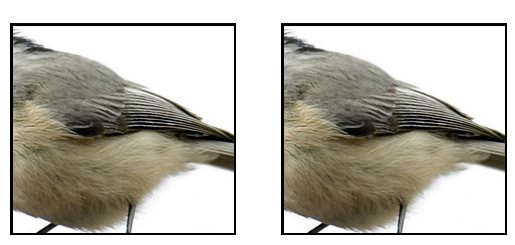

In [48]:
display_tensor_augmentation(sample['image'], None, sample['boxes'])

In [ ]:
sample[2]
import torchvision.datasets.coco

77